In [1]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
import cv2
from skimage import transform


/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Hyperparameters

#Output Shape
resolution = (128,128)

# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

# Size of Patch for PatchGAN
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters for G and D
filters_gen = 64

#Optimizer for the GAN.
optimizer = Adam(0.0004, 0.5)

def load_images(dataset,batch_size):
    chance = np.random.random()
    path = glob('cityscapes/train/*')
    images = np.random.choice(path, size=batch_size)
    img_real = []
    img_labelled = []

    for imagepath in images:
        img = cv2.imread(imagepath)
        width = img.shape[1]
        width = width//2
        real_img, labelled_img = img[:, width:, :],img[:, :width, :]
        real_img,labelled_img = transform.resize(real_img, resolution),transform.resize(labelled_img, resolution)
        if (chance<0.5):
            real_img = np.fliplr(real_img)
            labelled_img = np.fliplr(labelled_img)
        img_real.append(real_img)
        img_labelled.append(labelled_img)
    return np.array(img_labelled),np.array(img_real)
# REMEBER! - arr1(A) is the actual truth. arr2(B) is the labelled graphical image

# for batch_i, (imgs_A, imgs_B) in enumerate(load_images(1,2)):
#     print("hey")
arr1,arr2 = load_images(1,10)

/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


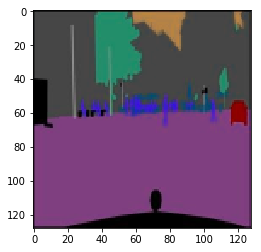

In [3]:
plt.imshow(arr2[0])

In [4]:
def new_generator():
    layer0 = Input(shape=img_shape,name="input")
    layer1 = Conv2D(filters_gen, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(layer0)
    bd = BatchNormalization(momentum=0.8)(layer1)
    layer2 = Conv2D(filters_gen*2, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer2)
    layer3 = Conv2D(filters_gen*4, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer3)
    layer4 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer4)
    layer5 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer5)
    layer6 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer6)
    dropout = Dropout(0.25)(bd)
    layer7 = Conv2D(filters_gen*8, kernel_size=2,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(dropout)
    bd = BatchNormalization(momentum=0.8)(layer7)
    def deconv2d(prev_layer, skip_input, filters):
        temp = UpSampling2D(size=2)(prev_layer)
        temp = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(temp)
        temp = BatchNormalization(momentum=0.6)(temp)
        temp = Concatenate()([temp, skip_input])
        return temp
    
    u_layer1 = deconv2d(bd, layer6, filters_gen*8)
    u_layer2 = deconv2d(u_layer1, layer5, filters_gen*8)
    u_layer3 = deconv2d(u_layer2, layer4, filters_gen*8)
    u_layer4 = deconv2d(u_layer3, layer3, filters_gen*4)
#     dropout = Dropout(0.25)
    u_layer5 = deconv2d(u_layer4, layer2, filters_gen*2)
    u_layer6 = deconv2d(u_layer5, layer1, filters_gen)
    u_layer7 = UpSampling2D(size=2)(u_layer6)
    u_layer0 = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u_layer7)
    return Model(layer0,u_layer0,name="Generator")


def new_discriminator():
    def d_layer(prev_layer, filters):
        temp = Conv2D(filters, kernel_size=4, strides=2, padding='same')(prev_layer)
        temp = LeakyReLU(alpha=0.2)(temp)
        return temp

    layer0_A = Input(shape=img_shape)
    layer0_B = Input(shape=img_shape)
    combined_input = Concatenate(axis=-1)([layer0_A, layer0_B])
    layer1 = d_layer(combined_input, filters_gen)
    layer2 = d_layer(layer1, filters_gen*2)
    layer3 = d_layer(layer2, filters_gen*4)
    layer4 = d_layer(layer3, filters_gen*8)
    layer5 = Conv2D(1, kernel_size=4, strides=1, padding='same')(layer4)
    return Model([layer0_A, layer0_B], layer5,name="Discriminator")

# heaven = new_discriminator()
# heaven.summary()


In [5]:
'''
1. Two images as input.
2. One image goes to generator
3. Two images go to the discriminator as input
4. We freeze the discriminator weights
5. Create GAN with both models. Inputs - B (Labelled Graphical) as earlier and outputs (A - Ground Truth) as earlier
'''
#<---Since the model is being compiled already here, 
# the flag later of trainable = False does not affect it.--->
d = new_discriminator()
d.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])


g = new_generator()

input_image_A = Input(shape = img_shape)
input_image_B = Input(shape = img_shape)

fake_image_B = g(input_image_B)
validity = d([fake_image_B,input_image_B])

#THIS ONLY STOPS THE TRAINING OF THE DISCRIMINATOR IN THE GAN. IT WILL STILL TRAIN WHEN INVOKED AS JUST D.
d.trainable = False

gan = Model(inputs=[input_image_A,input_image_B],outputs = [validity,fake_image_B],name="GAN")

gan.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
gan.summary()

/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 128, 128, 3)  38697859    input_4[0][0]                    
__________________________________________________________________________________________________
Discriminator (Model)           (None, 8, 8, 1)      2767809     Generator[1][0]                  
                                                                 input_4[0][0]                    
Total params: 41,465,668
Trainable params: 38,688,899
Non-trainable params: 2,776,769
__________________________________________________________________________________________________


In [11]:
def train(epochs,batch_size):
    valid_scores = np.ones((batch_size,disc_patch[0],disc_patch[1],disc_patch[2]))
    fake_scores = np.zeros((batch_size,disc_patch[0],disc_patch[1],disc_patch[2]))
    for j in range(epochs):
        print("Epoch -",j+1)
        start = datetime.datetime.now()
        for i in range(0,epochs):
    #         for batch_i, (images_A, images_B) in enumerate(load_images(1,2)):
            
            

            images_A,images_B = load_images(1,batch_size)
            fake_images = g.predict(images_B)

            #Discriminator losses
            d_loss_real = d.train_on_batch([images_A,images_B],valid_scores)
            d_loss_fake = d.train_on_batch([fake_images,images_B],fake_scores)
            avg_d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            #GAN losses
            gan_loss = gan.train_on_batch([images_A,images_B],[valid_scores,images_A])

        print("Discriminator Loss = ",avg_d_loss[0], "Accuracy =",avg_d_loss[1]*100)
        print("GAN Loss = ",gan_loss[0])
        end = start_time = datetime.datetime.now()
        print("Time Elapsed",end-start,"\n")
#     return avg_d_loss, gan_loss


In [ ]:
# Begin Training
train(30,32)

Epoch - 1


/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator Loss =  0.2501742 Accuracy = 57.4951171875
GAN Loss =  9.460614
Time Elapsed 0:00:51.112817 

Epoch - 2
Discriminator Loss =  276965.12 Accuracy = 0.2197265625
GAN Loss =  4580.9766
Time Elapsed 0:00:51.267068 

Epoch - 3
Discriminator Loss =  31.73731 Accuracy = 6.4453125
GAN Loss =  128.49863
Time Elapsed 0:00:51.583435 

Epoch - 4
Discriminator Loss =  16.48468 Accuracy = 8.7158203125
GAN Loss =  107.70843
Time Elapsed 0:00:51.622550 

Epoch - 5
Discriminator Loss =  9.486547 Accuracy = 12.98828125
GAN Loss =  101.2632
Time Elapsed 0:00:51.782915 

Epoch - 6


/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


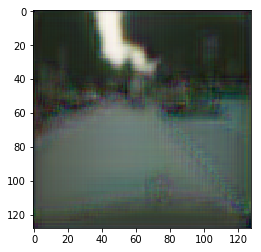

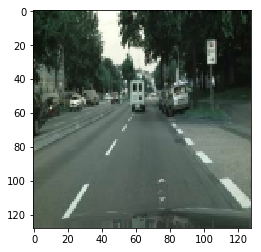

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


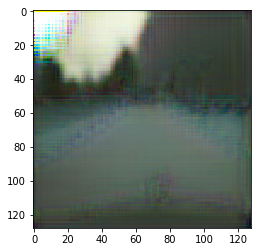

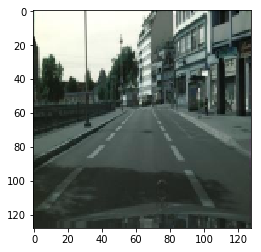

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


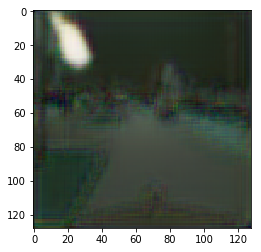

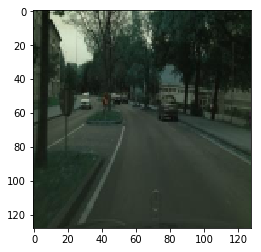

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


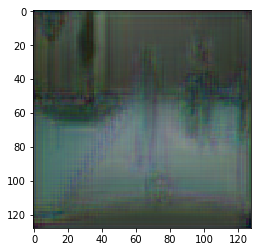

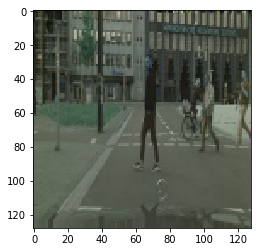

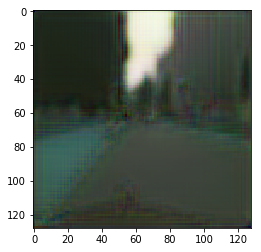

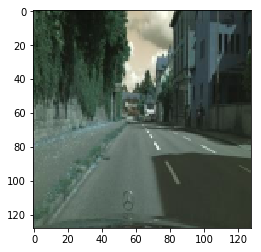

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


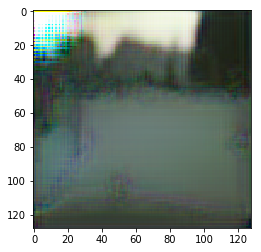

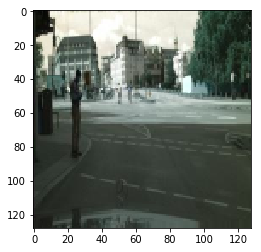

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


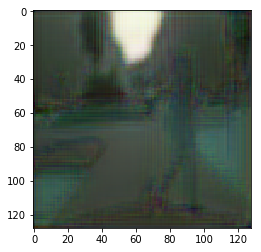

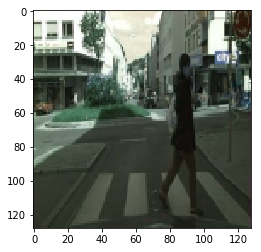

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


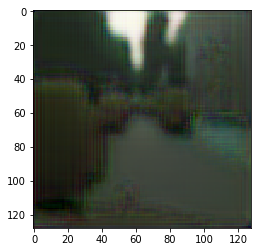

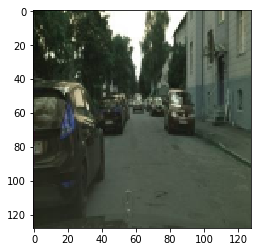

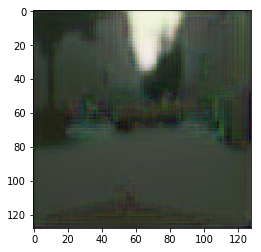

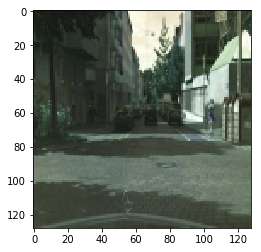

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


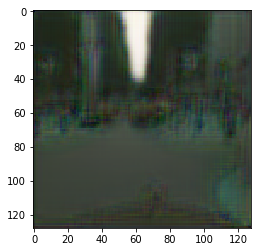

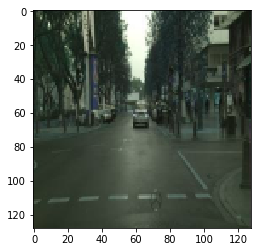

In [8]:
# Testing the GAN
for i in range(0,10):
    truth,labelled = load_images(1,1)
    predict = g.predict(labelled)
    plt.imshow(predict[0])
    plt.show()
    plt.imshow(truth[0])
    plt.show()


In [ ]:
# Saving Model
gan.save_weights('Weights/Cityscapes/GAN_weights.h5')
d.save_weights('Weights/Cityscapes/Discriminator_weights.h5')
